In this notebook I will implement the event-driven molecular dynamics simulation I explained in lesson 7.

Note: to get this notebook to run you need to install the `celluloid` package by opening anaconda prompt and running the command `pip install celluloid`, and also ffmpeg [follow these instructions](https://blog.gregzaal.com/how-to-install-ffmpeg-on-windows/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['animation.writer'] = 'ffmpeg'
import heapq as pq
from celluloid import Camera
from IPython.display import HTML
from math import isclose
myisclose = lambda x, y: isclose(x, y)
TOL = 1e-2

This next bit might be a little confusing. I am going to define an class to describe collisions that we  store in our pq. I need to define a class since an collision has several properties - the time at which it will happen, the type of collision (particle-particle, or particle-wall), and the particles involved in the collision.

This class also needs to provide a "less than" method so that heapq can sort them.

I'll also define a class which is basically a container to store the output of our simulations.

In [2]:
class Collision:
    # initialise a collision instance
    def __init__(self, t, collisionType, ind1, ind2, count1, count2):
        '''
        t: time at which the collision will occur
        collisiontype: string which is either 'particle' or 'wall', recording whether the collision is between two particles
        or between a particle and the wall
        ind1, ind2: For particle-particle collisions, ind1 and ind2 are the indices of the two particles.
        for particle-wall collisions, ind1 is the index of the particle and ind2 is the index of the wall. The convention is
        0: right wall, 1: top wall, 2: left wall, 3: bottom wall. 
        '''
        self.t = t
        self.count1 = count1
        self.count2 = count2
        if collisionType not in ['particle', 'wall']: raise ValueError('Collision type must be "particle" or "wall"')
        self.collisionType = collisionType
        if collisionType=='wall' and ind2 not in (0, 1, 2, 3): raise ValueError('Collision between particle and wall must have second index in (0, 1, 2, 3)')
        self.ind1 = ind1
        self.ind2 = ind2
    # Writing comparison functions so that heapq can make comparisons like "collision1 < collision2". See language reference:
    # https://docs.python.org/3/reference/datamodel.html#object.__lt__
    def __lt__(self, other):
        return self.t < other.t
    def __le__(self, other):
        return relf.t <= other.t
    def __eq__(self, other):
        return self.t == other.t
    def __ne__(self, other):
        return self.t != other.t
    def __gt__(self, other):
        return self.t > other.t
    def __ge__(self, other):
        return self.t >= other.t
    
    def isValid(self, collisionCount):
        if self.collisionType == 'wall':
            return self.count1 == collisionCount[self.ind1]
        else:
            return (self.count2 == collisionCount[self.ind2])

class OutContainer:
    def __init__(self, sampleTimes, ms, rs):
        N_particles = len(ms)
        N_timesamples = len(sampleTimes)
        self.ms = ms.copy()
        self.rs = rs.copy()
        self.t = sampleTimes.copy()
        self.vs = np.zeros((N_timesamples, N_particles, 2))
        self.xs = np.zeros_like(self.vs)
        self.E = np.zeros(N_timesamples)

Now we can get to the meat of it. I'm going to maintain the following objects (the number of particles is `N_particles`):
* an array of particle radii: size (N_particles, 1)
* an array of particle masses: size (N_particles, 1)
* an array of particle centre coordinates: size (n_Particles, 2)
* an array of particle velocities: size (n_Particles, 2)
* a `heapq` of Collision instances.
* the time

Before I can write the main simulation code, I need to write the following useful functions:
* advance: advances all the particles forward from time $t$ to time $t + \Delta t$
* resolveCollision: resolves a collision
* getEnergies: computes the energies of all the particles
* getNextCollision: gets the next collision(s) for a particle(s)

I'll write these functions in the cell below. Note that some of my functions work by modifying their arguments, which is a bit inelegant, and not great programming practice, but it avoids unnecessarily copying the position and velocity arrays, which could be large. This is possible due to the [view/copy distinction](https://www.jessicayung.com/numpy-views-vs-copies-avoiding-costly-mistakes/) in numpy.

In [86]:
def advance(xs, vs, t, tf):
    """
    xs: array of particle centre positions
    vs: array of particle velocities
    ms: array of particle masses
    t: current time
    tf: time to advance to
    note this function does not update the time
    """
    assert tf >=t
    xs +=  vs*(tf - t)

def resolveCollision(collision, rs, ms, xs, vs):
    if collision.collisionType == 'wall':
        return resolveCollisionWall(collision, rs, ms, xs, vs)
    else:
        return resolveCollisionParticle(collision, rs, ms, xs, vs)

def resolveCollisionParticle(collision, rs, ms, xs, vs):
    """
    collision: collision instance to resolve
    rs: array of particle radii
    vs: array of particle velocities
    ms: array of particle masses
    """

    # See https://algs4.cs.princeton.edu/61event/ for derivation and notation
    ind1 = collision.ind1
    ind2 = collision.ind2
    
    # check that the distance between the centres is equal to than the sum of the radii
    #assert myisclose(np.linalg.norm(xs[ind1]-xs[ind2]), rs[ind1]+rs[ind2])
    m1 = ms[ind1]
    m2 = ms[ind2]
    # Initial KE
    Ei = (0.5*m1*vs[ind1]**2).sum() + (0.5*m2*vs[ind2]**2).sum()
    sigma = rs[ind1] + rs[ind2]
    # difference in particle positions
    dr = xs[ind2] - xs[ind1]
    # difference in particle velocities
    dv = vs[ind2] - vs[ind1]
    # dot product
    drDotdv = dr.dot(dv)
    # Impulse
    J = (2*m1*m2*drDotdv) / (sigma*(m1+m2))
    Jx = J*dr[0]/sigma
    Jy = J*dr[1]/sigma
    
    # update velocities
    vs[ind1, 0] += Jx / m1
    vs[ind1, 1] += Jy / m1
    
    vs[ind2, 0] -= Jx / m2
    vs[ind2, 1] -= Jy / m2
    
    # final KE
    Ef = (0.5*m1*vs[ind1]**2).sum() + (0.5*m2*vs[ind2]**2).sum()
    # collision should conserve energy
    #assert myisclose(Ei, Ef)
     
def resolveCollisionWall(collision, rs, ms, xs, vs):
    # collision with left or right wall. In this case, we just need to reverse the x velocity of the particle
    if collision.ind2 in (0, 2):
        # let's add some sanity checking to avoid bugs. If the particle hits the top wall it should have been moving
        # upwards. Vice-versa for bottom wall
        if collision.ind2 == 0: assert vs[collision.ind1, 0] > 0
        elif collision.ind2 == 2: assert vs[collision.ind1, 0] < 0
        vs[collision.ind1, 0] *= -1
            
    # collision with top or bottom wall. In this case, we just need to reverse the y velocity of the particle
    elif collision.ind2 in (1, 3):
        # sanity checking as before
        if collision.ind2 == 1: assert vs[collision.ind1, 1] > 0
        elif collision.ind2 == 3: assert vs[collision.ind1, 1] < 0
        vs[collision.ind1, 1] *= -1

def getEnergies(ms, vs):
    return 0.5* ms * (vs[:, 0]**2 + vs[:, 1]**2)

def getTotalEnergy(ms, vs):
    return (0.5* ms * (vs[:, 0]**2 + vs[:, 1]**2)).sum()

def getNextCollision(ind, rs, xs, vs, t, collisionCount):
    collSideWall = getNextCollisionLRWall(ind, rs, xs, vs, t, collisionCount)
    collTopWall = getNextCollisionTBWall(ind, rs, xs, vs, t, collisionCount)
    collParticle = getNextCollisionParticle(ind, rs, xs, vs, t, collisionCount)
    # this bit of code works because we already implemented comparisons for collision events
    return min((collParticle, collTopWall, collSideWall))

def getNextCollisionLRWall(ind, rs, xs, vs, t, collisionCount):
    '''
    ind: index of particle
    t: current time
    '''
    vel = vs[ind, :]
    xx = xs[ind, :]
    sig = rs[ind]
    ind1 = ind
    # we'll find the next collision with the left or right wall, the next one with 
    
    # collision with right/left wall
    if vel[0] > 0:
        dtSide = (1 - sig - xx[0]) / vel[0]
        ind2 = 0
    elif vel[0] < 0:
        dtSide = (sig - xx[0]) / vel[0]
        ind2 = 2
    else:
        dtSide = np.inf
        ind2 = 2
    assert dtSide > 0
    return Collision(t+dtSide, 'wall', ind1, ind2, collisionCount[ind1], None)

def getNextCollisionTBWall(ind, rs, xs, vs, t, collisionCount):
    '''
    ind: index of particle
    t: current time
    '''
    vel = vs[ind, :]
    xx = xs[ind, :]
    sig = rs[ind]
    ind1 = ind    
    # collision with top/bottom wall
    if vel[1] > 0:
        dtTop = (1 - sig - xx[1]) / vel[1]
        ind2 = 1
    elif vel[1] < 0:
        dtTop = (sig - xx[1]) / vel[1]
        ind2 = 3
    else:
        dtTop = np.inf
        ind2 = 3
    return Collision(t+dtTop, 'wall', ind1, ind2, collisionCount[ind1], None)

    
def getNextCollisionParticle(ind, rs, xs, vs, t, collisionCount):
    '''
    ind: index of particle
    t: current time
    '''
    vel = vs[ind, :]
    xx = xs[ind, :]
    sig = rs[ind]
    ind1 = ind

    # collision with other particle. We'll loop through all the other particles and record the time until collision with
    # each particle. We'll keep track of the min value of dt, and the index for that value
    dtMin = np.inf
    indMin = 0
    for i in range(len(xs)):
        if i == ind1:
            dtcurr = np.inf
        else:
            dtCurr = timeToHit(ind1, i, rs, xs, vs)
            if dtCurr < dtMin:
                dtMin = dtCurr
                indMin = i
    return Collision(t + dtMin, 'particle', ind1, indMin, collisionCount[ind1], collisionCount[indMin])


def timeToHit(ind1, ind2, rs, xs, vs):
    #time until ind1 particle hits ind2 particle
    sig = rs[ind2] + rs[ind1]
    dr = xs[ind2] - xs[ind1]
    dv = vs[ind2] - vs[ind1]
    dvDotdv = dv.dot(dv)
    drDotdr = dr.dot(dr)
    dvDotdr = dv.dot(dr)
    d = dvDotdr**2 - dvDotdv*(drDotdr - sig**2)
    if dvDotdr >= 0 or d <0:
        return np.inf
    else:
        dt = - (dvDotdr + np.sqrt(d) ) / (dvDotdv)
        assert dt >= 0
        return dt

Now we can finally write the simulation! The algorithm is a tiny bit different to what I showed in the lesson because I want to be able to record the velocity, etc. at regular timesteps.

In [92]:
def takeSample(outContainer, xs, vs, ms, sampleInd):
    outContainer.xs[sampleInd, :, :] = xs.copy()
    outContainer.vs[sampleInd, :, :] = vs.copy()
    outContainer.E[sampleInd] = getTotalEnergy(ms, vs)

def checkForOverlap(xs, rs):
    for i in range(len(xs)):
        for j in range(i + 1, len(xs)):
            d = np.linalg.norm(xs[i] - xs[j])
            if d < rs[i] + rs[j]: return True
    return False

def doSim(v0s, x0s, rs, ms, sampleTimes):
    #Check if inital config is valid
    #assert not checkForOverlap(x0s, rs)
    N_particles = len(rs)
    out = OutContainer(sampleTimes, ms, rs)
    vs = v0s.copy()
    xs = x0s.copy()
    collisions = []
    collisionCount = np.zeros(N_particles, dtype=np.int32)
    sampleTimeInd = 0
    t = 0
    
    # first we need to populate the pq with the first collisions for all particles
    for i in range(N_particles):
        pq.heappush(collisions,  getNextCollision(i, rs, xs, vs, t, collisionCount))
    
    nextCollision = pq.heappop(collisions)
    nextSampleTime = sampleTimes[0]
    #print(nextCollision.collisionType)
    while sampleTimeInd < len(sampleTimes):
        #assert (xs>=0).all() and (xs<= 1).all()
        if nextSampleTime < nextCollision.t:
            #print('sample')
            advance(xs, vs, t,  nextSampleTime)
            t = nextSampleTime
            takeSample(out, xs, vs, ms, sampleTimeInd)
            # break if we have taken the last time sample
            if sampleTimeInd == len(sampleTimes) - 1: break
            sampleTimeInd += 1
            nextSampleTime = sampleTimes[sampleTimeInd]
        elif nextCollision.t < nextSampleTime:
            #print('event')
            # only resolve if it was valid
            if nextCollision.isValid(collisionCount):
                advance(xs, vs, t,  nextCollision.t)
                t = nextCollision.t
                resolveCollision(nextCollision, rs, ms, xs, vs)
                collisionCount[nextCollision.ind1] += 1
                pq.heappush(collisions, getNextCollision(nextCollision.ind1, rs, xs, vs, t, collisionCount))
                # if it was a particle-particle collision, we need to push the next collision time for the second particle
                # as well
                if nextCollision.collisionType == "particle":
                    collisionCount[nextCollision.ind2] += 1
                    pq.heappush(collisions, getNextCollision(nextCollision.ind2, rs, xs, vs, t, collisionCount))
            nextCollision = pq.heappop(collisions)
            #print(nextCollision.collisionType)
        #sample and collision happen at the same time. Seems unlikely (but might happen when you choose
        # round numbers for init). Sample before collision (we have to make an arbitrary choice)
        else:
            #print('sample and event')
            advance(xs, vs, t,  nextSampleTime)
            t = nextSampleTime
            takeSample(out, xs, vs, ms, sampleTimeInd)
            # break if we have taken the last time sample
            if sampleTimeInd == len(sampleTimes) - 1: break
            sampleTimeInd += 1
            nextSampleTime = sampleTimes[sampleTimeInd]
            if nextCollision.isValid(collisionCount):
                advance(xs, vs, t,  nextCollision.t)
                t = nextCollision.t
                resolveCollision(nextCollision, rs, ms, xs, vs)
                collisionCount[nextCollision.ind1] += 1
                pq.heappush(collisions, getNextCollision(nextCollision.ind1, rs, xs, vs, t, collisionCount))
                # if it was a particle-particle collision, we need to push the next collision time for the second particle
                # as well
                if nextCollision.collisionType == "particle":
                    print('ddd')
                    collisionCount[nextCollision.ind2] += 1
                    pq.heappush(collisions, getNextCollision(nextCollision.ind2, rs, xs, vs, t, collisionCount))
            nextCollision = pq.heappop(collisions)
            print(nextCollision.collisionType)
    return out

def animateResults(out):
    plt.ioff()
    fig = plt.figure()
    ax = plt.gca()
    camera = Camera(fig)
    for i in range(len(out.t)):
        xs = out.xs[i, :]
        for i in range(xs.shape[0]):
            ax.add_artist(plt.Circle((xs[i, 0], xs[i, 1]), out.rs[i]))
        camera.snap()
    return camera.animate()

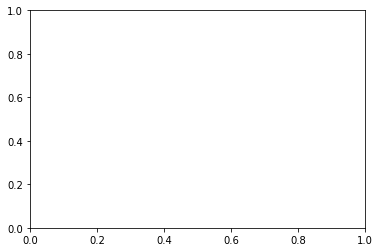

In [54]:
def doOneBall():
    ms = np.array([1.0])
    rs = np.array([0.1])
    x0s = np.array([[0.5, 0.5]])
    v0s = np.array([[1, 0.5]])
    sampleTimes = np.linspace(0, 10, 500)
    out = doSim(v0s, x0s, rs, ms, sampleTimes)
    return out
out = doOneBall()
animation = animateResults(out)
HTML(animation.to_html5_video())

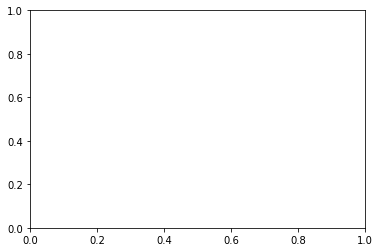

In [62]:
def twoParticleSim():
    ms = np.array([1.0, 1.0])
    rs = np.array([0.1, 0.1])
    x0s = np.array([[0.2, 0.5], [0.8, 0.5]])
    v0s = np.array([[1.0, 0.5], [-1.0, 0]])
    sampleTimes = np.linspace(0, 10, 500)
    out = doSim(v0s, x0s, rs, ms, sampleTimes)
    return out
out = twoParticleSim()
animation = animateResults(out)
HTML(animation.to_html5_video())
